> 应用RNN模型预测单词所属语言
> 参考链接：https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

> kidzying 2022.05.13

In [46]:
from __future__ import unicode_literals, print_function, division
from io import open

# 本模块用于查找文件路径
import glob
import os

# 本模块处理unicode字符相关
import unicodedata
import string

import torch

# 准备数据

In [3]:
def findFiles(path): 
    return glob.glob(path)

# 通配符※匹配0个或多个字符
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [6]:
all_letters = string.ascii_letters + " .,;'"
# 总共有多少个字母
n_letters = len(all_letters)

n_letters

57

In [7]:
unicodedata.normalize('NFC','Ślusàrsk')

'Ślusàrsk'

In [8]:
unicodedata.normalize('NFKD','Ślusàrsk')

'Ślusàrsk'

In [9]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [10]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# 共有多少种语言：
n_categories

18

In [11]:
# 从all_letters中查找单个字母的下标, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [12]:
letterToIndex('a')

0

In [13]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [14]:
letterToTensor('a')

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [15]:
# 将一行单词转换为对应的tensor张量
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

# 构建RNN模型

In [24]:
import torch.nn as nn

RNN结构如下：

<img src = "pic/rnn.png" width="350" height="450">

In [17]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
# n_letters为57（有多少个字母），n_categories为18（有多少种语言分类）
rnn = RNN(n_letters, n_hidden, n_categories)

In [20]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(output)

tensor([[-2.9022, -2.8622, -2.8652, -2.8353, -2.9390, -2.9394, -2.8571, -2.9427,
         -2.8020, -2.9713, -2.8042, -2.8765, -2.9536, -2.8119, -2.9350, -2.9175,
         -2.9584, -2.8798]], grad_fn=<LogSoftmaxBackward0>)


In [21]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9022, -2.8622, -2.8652, -2.8353, -2.9390, -2.9394, -2.8571, -2.9427,
         -2.8020, -2.9713, -2.8042, -2.8765, -2.9536, -2.8119, -2.9350, -2.9175,
         -2.9584, -2.8798]], grad_fn=<LogSoftmaxBackward0>)


In [23]:
output.topk(1)

torch.return_types.topk(
values=tensor([[-2.8020]], grad_fn=<TopkBackward0>),
indices=tensor([[8]]))

In [28]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Irish', 8)


# 随机生成训练数据

In [29]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Lolos
category = Polish / line = Niemczyk
category = German / line = Hoch
category = Chinese / line = Chang
category = Czech / line = Metjeka
category = German / line = Schroter
category = Portuguese / line = Henriques
category = Russian / line = Yachmentsev
category = Russian / line = Omelchenko
category = Irish / line = O'Neill


In [30]:
# 定义损失函数
criterion = nn.NLLLoss()

In [31]:
# 设置学习率
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # 模型梯度归0
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# 模型训练

In [32]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 3s) 2.3746 Tivoli / Italian ✓
10000 10% (0m 7s) 2.9452 Albuquerque / Russian ✗ (Portuguese)
15000 15% (0m 10s) 1.7128 Madeira / Italian ✗ (Portuguese)
20000 20% (0m 14s) 1.2476 Sommer / German ✓
25000 25% (0m 18s) 2.4961 Severijns / Greek ✗ (Dutch)
30000 30% (0m 21s) 0.0553 Antonopoulos / Greek ✓
35000 35% (0m 25s) 3.5013 Kakinomoto / Italian ✗ (Japanese)
40000 40% (0m 29s) 0.2415 Geng / Chinese ✓
45000 45% (0m 32s) 1.9374 Nani / Chinese ✗ (Italian)
50000 50% (0m 36s) 0.7703 Dubhshlaine / Irish ✓
55000 55% (0m 39s) 1.5484 Ahn / Vietnamese ✗ (Korean)
60000 60% (0m 43s) 0.6654 Kouri / Arabic ✓
65000 65% (0m 46s) 1.2793 Aquila / Spanish ✗ (Italian)
70000 70% (0m 50s) 0.7486 Nao / Chinese ✓
75000 75% (0m 53s) 0.1201 Shon / Korean ✓
80000 80% (0m 57s) 0.3838 Kouri / Arabic ✓
85000 85% (1m 0s) 0.9889 Thomson / Scottish ✓
90000 90% (1m 4s) 0.6257 Robertson / Scottish ✓
95000 95% (1m 7s) 0.9601 Paget / French ✓
100000 100% (1m 11s) 6.8718 Mustafa / Arabic ✗ (English)


绘制损失函数变化

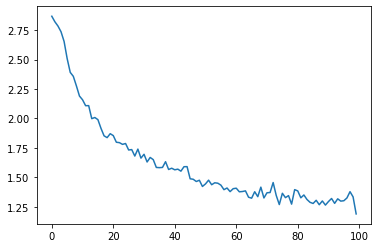

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 使用混淆矩阵评估模型结果

/var/folders/1s/bcj1yf0102qftz9bm5xcr1v00000gn/T/ipykernel_6015/17933315.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/1s/bcj1yf0102qftz9bm5xcr1v00000gn/T/ipykernel_6015/17933315.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


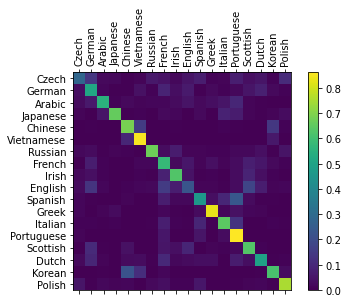

In [42]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# 应用模型预测

In [29]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('WeiXian')


> Dovesky
(-0.46) Czech
(-1.61) Russian
(-2.62) English

> Jackson
(-0.34) Scottish
(-1.68) English
(-3.07) Dutch

> Satoshi
(-0.65) Italian
(-1.50) Japanese
(-2.90) Polish

> WeiXian
(-1.50) Vietnamese
(-1.53) Chinese
(-2.01) Japanese
